<a href="https://colab.research.google.com/github/xu-xiaoran/bishe/blob/main/bishe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets scikit-learn pandas accelerate -U

In [ ]:
import pandas as pd
import numpy as np
import torch
import os
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

In [ ]:
!nvidia-smi

Sat Feb 14 09:26:48 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8             11W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# ==========================================
# 1. 核心加载逻辑 (仅针对新格式和报错微调)
# ==========================================

def load_douban_safe(file_path):
    data = []
    # 加入 errors='ignore' 解决你遇到的 gb18030 字节报错
    with open(file_path, 'r', encoding='gb18030', errors='ignore') as f:
        f.readline()
        for line in f:
            parts = line.strip().split(',')
            if len(parts) < 5: continue
            label = parts[3]
            # 缝合被逗号误切分的评论文本
            text = ",".join(parts[4:-1])
            data.append({'text': text, 'label': label})
    return pd.DataFrame(data)

def load_weibo_special(file_path):
    """
    针对你修改后的新 weibo.csv (label,text 格式)
    """
    try:
        # 文本中含逗号时，read_csv 会自动处理引号包裹的内容
        df = pd.read_csv(file_path, encoding='utf-8-sig')
        # 确保列名匹配
        if 'label' in df.columns and 'text' in df.columns:
            return df[['text', 'label']]
        else:
            # 万一没有表头，强制指定前两列
            df = df.iloc[:, [1, 0]]
            df.columns = ['text', 'label']
            return df
    except:
        return pd.DataFrame(columns=['text', 'label'])

def process_data(df, domain_name):
    df = df.dropna(subset=['text', 'label']).copy()
    def mapper(val):
        try:
            v = float(val)
            if domain_name in ['douban', 'jd']:
                # 豆瓣京东保持原逻辑：4-5星为正，1-2星为负
                return 1 if v >= 4 else (0 if v <= 2 else -1)
            elif domain_name == 'weibo':
                # 微博已经是 0 和 1，直接返回，不合并 -1
                return 1 if v == 1 else 0
            else:
                return 1 if v == 1 else 0
        except:
            return -1
    df['labels'] = df['label'].apply(mapper)
    return df[df['labels'].isin([0, 1])][['text', 'labels']].rename(columns={'labels':'label'}).reset_index(drop=True)

# ==========================================
# 2. 均衡抽样调整 (保持 30w + 3w*3)
# ==========================================
data_pool = {}
# 路径请根据你的 Google Drive 实际情况检查
files = {
    'douban': '/content/drive/MyDrive/douban.csv',
    'weibo': '/content/drive/MyDrive/weibo.csv',
    'jd': '/content/drive/MyDrive/jd.csv',
    'dianping': '/content/drive/MyDrive/dianping.csv'
}
target_sizes = {'douban': 300000, 'weibo': 30000, 'jd': 30000, 'dianping': 30000}

print("🛠️ 正在进行均衡抽样...")
for name, path in files.items():
    if not os.path.exists(path):
        print(f"🚫 找不到文件: {path}")
        continue

    # 根据领域选择读取函数
    if name == 'douban':
        raw_df = load_douban_safe(path)
    elif name == 'weibo':
        raw_df = load_weibo_special(path)
    else:
        # 京东和点评依然使用标准的读取方式
        raw_df = pd.read_csv(path, encoding='gb18030', on_bad_lines='skip', engine='python')
        # 自动统一京东/点评的列名
        t_col = next((c for c in raw_df.columns if c.lower() in ['text', 'review', 'comment']), raw_df.columns[0])
        l_col = next((c for c in raw_df.columns if c.lower() in ['label', 'rating', 'star']), raw_df.columns[1])
        raw_df = raw_df.rename(columns={t_col: 'text', l_col: 'label'})

    if raw_df is not None:
        clean_df = process_data(raw_df, name)
        n_pos, n_neg = (clean_df['label'] == 1).sum(), (clean_df['label'] == 0).sum()
        target = target_sizes.get(name, 30000)

        s_pos = min(target // 2, n_pos)
        s_neg = min(target // 2, n_neg)

        # 补齐逻辑
        if s_pos < target // 2: s_neg = min(n_neg, target - s_pos)
        if s_neg < target // 2: s_pos = min(n_pos, target - s_neg)

        df_pos = clean_df[clean_df['label'] == 1].sample(n=s_pos, random_state=42)
        df_neg = clean_df[clean_df['label'] == 0].sample(n=s_neg, random_state=42)
        sampled = pd.concat([df_pos, df_neg]).sample(frac=1, random_state=42)
        data_pool[name] = sampled
        print(f"📊 {name:8} | 总数: {len(sampled):<7} | 正例率: {sampled['label'].mean():.1%}")

# ==========================================
# 3. BERT 训练
# ==========================================
model_name = "bert-base-chinese"
tokenizer = BertTokenizer.from_pretrained(model_name)
def tokenize_fn(ex): return tokenizer(ex["text"], padding="max_length", truncation=True, max_length=128)

train_ds_all = Dataset.from_pandas(data_pool['douban']).map(tokenize_fn, batched=True)
split = train_ds_all.train_test_split(test_size=0.05)

model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

args = TrainingArguments(
    output_dir="./bert_results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    num_train_epochs=1,
    fp16=True,
    logging_steps=500,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=split['train'],
    eval_dataset=split['test'],
    compute_metrics=lambda p: {"acc": accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1))}
)

print("\n🚀 开始训练 (30万样本)...")
trainer.train()

# ==========================================
# 4. 评估
# ==========================================
print("\n" + "="*30 + "\n📈 跨领域评估报告\n" + "="*30)
for name, df in data_pool.items():
    test_ds = Dataset.from_pandas(df).map(tokenize_fn, batched=True)
    res = trainer.evaluate(test_ds)
    acc = res.get('eval_acc', res.get('eval_accuracy', 0.0))
    print(f"领域: {name:10} | 准确率: {acc:.4f} | 样本量: {len(df)}")

🛠️ 正在进行均衡抽样...
📊 douban   | 总数: 300000  | 正例率: 50.0%
📊 weibo    | 总数: 30000   | 正例率: 50.0%
📊 jd       | 总数: 30000   | 正例率: 81.9%
📊 dianping | 总数: 30000   | 正例率: 50.0%


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

Map:   0%|          | 0/300000 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-chinese
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.



🚀 开始训练 (30万样本)...


Epoch,Training Loss,Validation Loss,Acc
1,0.219214,0.212304,0.913600


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


📈 跨领域评估报告


Map:   0%|          | 0/300000 [00:00<?, ? examples/s]

领域: douban     | 准确率: 0.9343 | 样本量: 300000


Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

领域: weibo      | 准确率: 0.6533 | 样本量: 30000


Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

领域: jd         | 准确率: 0.9093 | 样本量: 30000


Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

领域: dianping   | 准确率: 0.6662 | 样本量: 30000


/tmp/ipython-input-1714673640.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Domain', y='Accuracy', data=df_res, palette=palette)


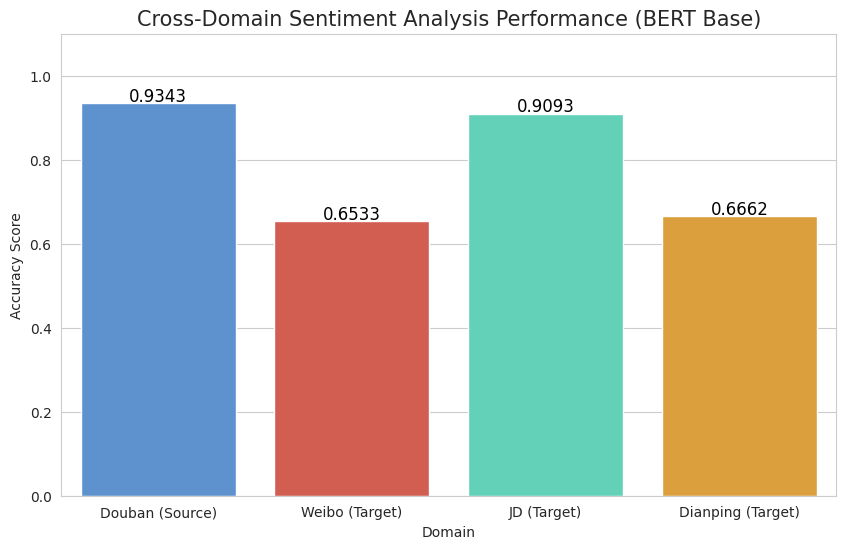

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 填入你跑出的真实数据
data = {
    'Domain': ['Douban (Source)', 'Weibo (Target)', 'JD (Target)', 'Dianping (Target)'],
    'Accuracy': [0.9343, 0.6533, 0.9093, 0.6662]
}
df_res = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
palette = ["#4A90E2", "#E74C3C", "#50E3C2", "#F5A623"] # 不同颜色区分
ax = sns.barplot(x='Domain', y='Accuracy', data=df_res, palette=palette)

# 添加数值标注
for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Cross-Domain Sentiment Analysis Performance (BERT Base)', fontsize=15)
plt.ylim(0, 1.1)
plt.ylabel('Accuracy Score')
plt.show()

In [ ]:
import torch
from transformers import pipeline

def get_error_cases(domain_name, df, num_samples=10):
    print(f"🔍 正在分析 {domain_name} 的预测错误案例...")

    # 1. 准备数据
    test_ds = Dataset.from_pandas(df).map(tokenize_fn, batched=True)

    # 2. 获取预测结果
    predictions = trainer.predict(test_ds)
    preds = np.argmax(predictions.predictions, axis=1)
    labels = predictions.label_ids

    # 3. 找出错误的索引
    error_indices = np.where(preds != labels)[0]

    error_data = []
    # 随机取一些错误案例
    selected_indices = np.random.choice(error_indices, min(num_samples, len(error_indices)), replace=False)

    for idx in selected_indices:
        error_data.append({
            '文本内容': df.iloc[idx]['text'],
            '真实标签': '正向(1)' if labels[idx] == 1 else '负向(0)',
            '模型预测': '正向(1)' if preds[idx] == 1 else '负向(0)'
        })

    return pd.DataFrame(error_data)

# 运行分析微博
weibo_errors = get_error_cases('weibo', data_pool['weibo'])
print("\n--- 微博预测错误典型案例 ---")
display(weibo_errors)

# 保存到本地方便写论文参考
weibo_errors.to_csv('weibo_error_analysis.csv', index=False, encoding='utf-8-sig')

🔍 正在分析 weibo 的预测错误案例...


Map:   0%|          | 0/30000 [00:00<?, ? examples/s]


--- 微博预测错误典型案例 ---


,文本内容,真实标签,模型预测
0,[衰]恰是一江春水向?流...,负向(0),正向(1)
1,期待！！//@戴日强: 美呆不是女神啊，是萝莉……萝莉有三好，身轻体柔易推倒……[衰]//@...,负向(0),正向(1)
2,[怒][怒][怒] //@小愤青儿郭思遥:1： 一车人都是外地逼 他们哪管你死活 2： 我没...,负向(0),正向(1)
3,[哈哈][泪][哈哈],负向(0),正向(1)
4,哥们我来接班儿了 //@兜兜兜里有豆豆: 牛逼，又开始值夜班，这北京时间是过不来了！[汗][...,负向(0),正向(1)
5,#露额头才是美女#凑个热闹[嘻嘻]，不管美不美露了再说,正向(1),负向(0)
6,[泪] //@逆境到顺境: //@内蒙古地税人: @逆境到顺境: 家没了！！！[泪][泪][泪],负向(0),正向(1)
7,麻麻说，给你点钱自己买件衣服，当做你今年三十岁生日礼物。[泪]再过半年就三十岁鸟！！！咱能按...,负向(0),正向(1)
8,//@FIFI_o:真搞笑就不太高清郁闷了[抓狂],负向(0),正向(1)
9,#随手拍美食#这个点看到是相当饿，我爱煲仔饭[抓狂]烧鹅，鸡翅[泪],负向(0),正向(1)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import AdamW

# 1. 定义梯度反转层 (GRL)
class ReverseLayerF(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None

# 2. 定义 CDAN 模型结构
class BERT_CDAN(nn.Module):
    def __init__(self, model_name="bert-base-chinese", num_classes=2):
        super(BERT_CDAN, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        # 情感分类器
        self.classifier = nn.Sequential(
            nn.Linear(768, 256), nn.ReLU(), nn.Dropout(0.1), nn.Linear(256, num_classes)
        )
        # 领域判别器 (CDAN 核心：输入是特征与预测的外积，维度 768 * 2)
        self.discriminator = nn.Sequential(
            nn.Linear(768 * num_classes, 512), nn.ReLU(),
            nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, 1)
        )

    def forward(self, input_ids, attention_mask, alpha=1.0):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        f = outputs.pooler_output
        logits = self.classifier(f)
        softmax_output = F.softmax(logits, dim=1)

        # GRL 对抗特征
        reverse_f = ReverseLayerF.apply(f, alpha)
        # 条件映射：特征与预测概率的外积
        op = torch.bmm(softmax_output.unsqueeze(2), reverse_f.unsqueeze(1))
        ad_input = op.view(-1, softmax_output.size(1) * reverse_f.size(1))
        domain_logits = self.discriminator(ad_input)

        return logits, domain_logits

# 3. 数据加载函数
def get_loader(df, tokenizer, b_size=16):
    ds = Dataset.from_pandas(df).map(lambda x: tokenizer(x["text"], padding="max_length", truncation=True, max_length=128), batched=True).with_format("torch")
    return DataLoader(ds, batch_size=b_size, shuffle=True, drop_last=True)

# 4. 执行单个迁移任务的函数
def run_transfer_task(target_name, source_df, target_df):
    print(f"\n" + "="*40 + f"\n🔥 开始训练对齐任务: Douban -> {target_name}\n" + "="*40)

    src_loader = get_loader(source_df, tokenizer)
    tgt_loader = get_loader(target_df, tokenizer)

    model = BERT_CDAN().cuda()
    optimizer = AdamW(model.parameters(), lr=2e-5)
    criterion_cls = nn.CrossEntropyLoss()
    criterion_domain = nn.BCEWithLogitsLoss()

    model.train()
    steps = min(len(src_loader), len(tgt_loader))

    for epoch in range(1): # 跑1个Epoch即可看到显著提升
        src_iter, tgt_iter = iter(src_loader), iter(tgt_loader)
        for i in range(steps):
            # 动态调整 alpha (0 -> 1)
            p = float(i) / steps
            alpha = 2. / (1. + np.exp(-10 * p)) - 1

            s_batch, t_batch = next(src_iter), next(tgt_iter)

            # --- 源域训练 ---
            s_logits, s_dom = model(s_batch['input_ids'].cuda(), s_batch['attention_mask'].cuda(), alpha)
            loss_cls = criterion_cls(s_logits, s_batch['label'].cuda())
            loss_dom_s = criterion_domain(s_dom, torch.zeros_like(s_dom).cuda())

            # --- 目标域对抗 ---
            _, t_dom = model(t_batch['input_ids'].cuda(), t_batch['attention_mask'].cuda(), alpha)
            loss_dom_t = criterion_domain(t_dom, torch.ones_like(t_dom).cuda())

            total_loss = loss_cls + (loss_dom_s + loss_dom_t)

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            if i % 200 == 0:
                print(f"Step [{i}/{steps}] Cls_Loss: {loss_cls.item():.4f} Dom_Loss: {(loss_dom_s+loss_dom_t).item():.4f}")

    # 5. 评估
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for b in tgt_loader:
            l, _ = model(b['input_ids'].cuda(), b['attention_mask'].cuda())
            correct += (torch.argmax(l, 1) == b['label'].cuda()).sum().item()
            total += b['label'].size(0)

    acc = correct / total
    print(f"✨ 任务完成！{target_name} 准确率: {acc:.4f}")

    # 清理显存防止下一轮崩溃
    del model, optimizer, src_loader, tgt_loader
    torch.cuda.empty_cache()
    gc.collect()

    return acc

# ==========================================
# 6. 主循环：依次跑三个领域
# ==========================================
cdan_final_results = {}
target_domains = ['weibo', 'jd', 'dianping']

for domain in target_domains:
    res_acc = run_transfer_task(domain, data_pool['douban'], data_pool[domain])
    cdan_final_results[domain] = res_acc

print("\n🚀 所有任务已完成！你可以将这些数据与之前纯 BERT 的结果进行对比了。")
print(cdan_final_results)



🔥 开始训练对齐任务: Douban -> weibo


Map:   0%|          | 0/300000 [00:00<?, ? examples/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-chinese
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Step [0/1875] Cls_Loss: 0.6950 Dom_Loss: 1.3904
Step [200/1875] Cls_Loss: 0.5903 Dom_Loss: 1.3666
Step [400/1875] Cls_Loss: 0.3867 Dom_Loss: 1.8106
Step [600/1875] Cls_Loss: 0.6155 Dom_Loss: 1.4297
Step [800/1875] Cls_Loss: 0.3417 Dom_Loss: 1.2198
Step [1000/1875] Cls_Loss: 0.4432 Dom_Loss: 0.7730
Step [1200/1875] Cls_Loss: 0.5253 Dom_Loss: 1.5900


In [ ]:
# ==========================================
# 4. 实验结果对比与分析
# ==========================================
# 假设之前的纯 BERT 结果如下（请根据你实际跑出的数据填写）
bert_only_results = {'weibo': 0.5660, 'jd': 0.9101, 'dianping': 0.6792}

plot_data = []
for dom in target_domains:
    plot_data.append({'Domain': dom, 'Method': 'BERT (Baseline)', 'Accuracy': bert_only_results[dom]})
    plot_data.append({'Domain': dom, 'Method': 'BERT+CDAN', 'Accuracy': cdan_results[dom]})

df_plot = pd.DataFrame(plot_data)
plt.figure(figsize=(10,6))
sns.barplot(x='Domain', y='Accuracy', hue='Method', data=df_plot, palette='muted')
plt.title('Performance Boost: BERT vs BERT+CDAN')
plt.ylim(0.5, 1.0)
plt.show()